# Práctica transferencia de conocimiento

Ahora vais a implementar vosotros mismos transferencia de conocimiento sobre otra base de datos. Vamos a hacer uso de una base de datos que tiene imágenes de flores de 5 clases diferentes.

In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from matplotlib.ticker import MultipleLocator

from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
import os

In [10]:
data_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

In [11]:
print(data_root)

C:\Users\jsanchez\.keras\datasets\flower_photos


In [12]:
print(list(Path(data_root).iterdir()))

[WindowsPath('C:/Users/jsanchez/.keras/datasets/flower_photos/daisy'), WindowsPath('C:/Users/jsanchez/.keras/datasets/flower_photos/dandelion'), WindowsPath('C:/Users/jsanchez/.keras/datasets/flower_photos/LICENSE.txt'), WindowsPath('C:/Users/jsanchez/.keras/datasets/flower_photos/roses'), WindowsPath('C:/Users/jsanchez/.keras/datasets/flower_photos/sunflowers'), WindowsPath('C:/Users/jsanchez/.keras/datasets/flower_photos/tulips')]


En este caso, a diferencia del anterior, no tenemos las imágenes en 2 carpetas correspondientes a las imágenes de entrenamiento y validación, sino que tenemos directamente las 5 carpetas correspondientes a los 5 tipos de flores. Vamos a ver como podemos crear ambos datasets en este caso.

In [13]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_root,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_root,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [14]:
class_names = np.array(train_dataset.class_names)
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


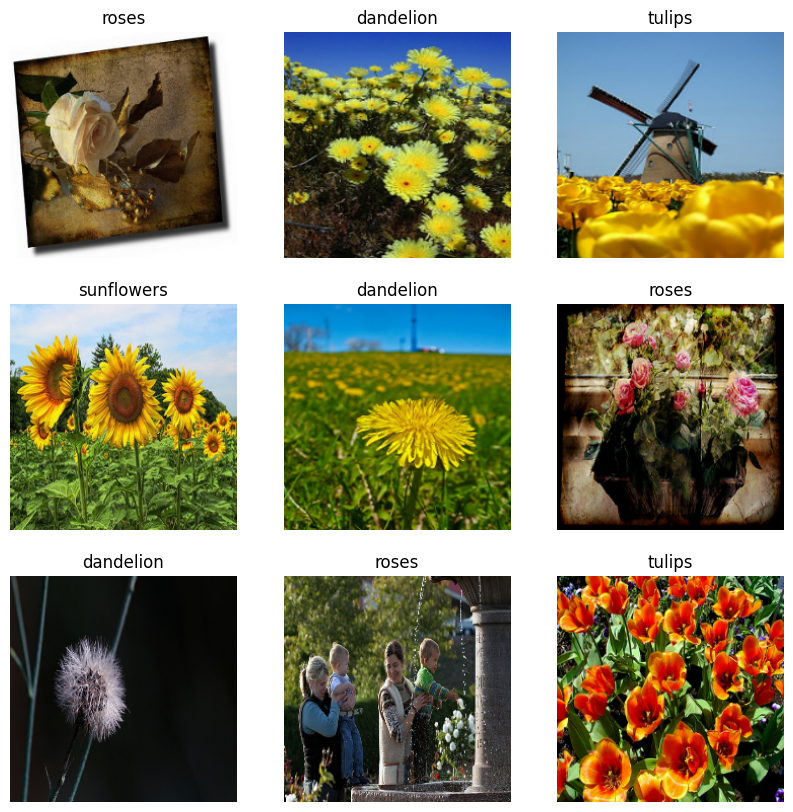

In [15]:
# Visualizamos imágenes
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [16]:
# Evistamos bloqueo E/S

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

## Ejercicio 2

Vamos a entrenar una arquitectura base con esta nueva base de datos.

Para ello, adapta la arquitectura del Ejercicio 1 (anterior notebook) para resolver un problema de clasificación  de 5 clases.

Compila el modelo haciendo uso del optimizador Adam, función de coste "sparse_categorical_crossentropy" (luego veremos por qué) y la exactitud como métrica. A continuación, entrena el modelo durante 15 épocas y, finalmente, muestra las curvas de aprendizaje (entrenamiento vs. validación).

In [17]:
input_layer = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

layer_conv_1 = layers.Conv2D(filters=12, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(
    input_layer)
batch_normalization_1 = layers.BatchNormalization()(layer_conv_1)

layer_conv_2 = layers.Conv2D(filters=12, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(
    batch_normalization_1)
batch_normalization_2 = layers.BatchNormalization()(layer_conv_2)

max_pooling_1 = layers.MaxPool2D(pool_size=(2, 2))(batch_normalization_2)

layer_conv_3 = layers.Conv2D(filters=25, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(
    max_pooling_1)
batch_normalization_3 = layers.BatchNormalization()(layer_conv_3)
layer_conv_4 = layers.Conv2D(filters=25, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(
    batch_normalization_3)
batch_normalization_4 = layers.BatchNormalization()(layer_conv_4)
max_pooling_2 = layers.MaxPooling2D(pool_size=(2, 2))(batch_normalization_4)

layer_conv_5 = layers.Conv2D(filters=51, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(
    max_pooling_2)
batch_normalization_5 = layers.BatchNormalization()(layer_conv_5)
layer_conv_6 = layers.Conv2D(filters=51, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(
    batch_normalization_5)
batch_normalization_6 = layers.BatchNormalization()(layer_conv_6)
global_avg = layers.GlobalAveragePooling2D()(batch_normalization_6)

dense_1 = layers.Dense(12, activation="relu")(global_avg)
dense_2 = layers.Dense(5, activation="softmax")(dense_1)

model = Model(inputs=[input_layer], outputs=[dense_2])

In [18]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
# Carpeta en la que guardar los modelos
path_model_save = os.path.join(os.getcwd(), 'Practice02')
if not os.path.exists(path_model_save):
    os.mkdir(path_model_save)

In [21]:
def scaling_normalization(image, label):
    image = tf.cast(image / 255., tf.float32)
    return image, label


train_dataset_norm = train_dataset.map(scaling_normalization)
validation_dataset_norm = validation_dataset.map(scaling_normalization)

In [22]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(path_model_save, 'flowers.h5'),
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=True
)

history = model.fit(train_dataset_norm,
                    epochs=15,
                    validation_data=validation_dataset_norm,
                    callbacks=[model_checkpoint_callback],
                    verbose=True)

Epoch 1/15
92/92 [==============================] - ETA: 0s - loss: 1.2469 - accuracy: 0.5044
Epoch 1: val_accuracy improved from -inf to 0.23978, saving model to C:\PersonalStuff\IABD\ProgramacionInteligenciaArtificial\Ana\Unit04-KnowledgeTransfer\Practices\Practice02\flowers.h5
92/92 [==============================] - 70s 748ms/step - loss: 1.2469 - accuracy: 0.5044 - val_loss: 1.9313 - val_accuracy: 0.2398
Epoch 2/15


C:\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


92/92 [==============================] - ETA: 0s - loss: 1.0560 - accuracy: 0.5937
Epoch 2: val_accuracy did not improve from 0.23978
92/92 [==============================] - 69s 747ms/step - loss: 1.0560 - accuracy: 0.5937 - val_loss: 2.3221 - val_accuracy: 0.2398
Epoch 3/15
92/92 [==============================] - ETA: 0s - loss: 0.9632 - accuracy: 0.6260
Epoch 3: val_accuracy improved from 0.23978 to 0.25341, saving model to C:\PersonalStuff\IABD\ProgramacionInteligenciaArtificial\Ana\Unit04-KnowledgeTransfer\Practices\Practice02\flowers.h5
92/92 [==============================] - 69s 742ms/step - loss: 0.9632 - accuracy: 0.6260 - val_loss: 2.1896 - val_accuracy: 0.2534
Epoch 4/15
92/92 [==============================] - ETA: 0s - loss: 0.9249 - accuracy: 0.6526
Epoch 4: val_accuracy improved from 0.25341 to 0.28065, saving model to C:\PersonalStuff\IABD\ProgramacionInteligenciaArtificial\Ana\Unit04-KnowledgeTransfer\Practices\Practice02\flowers.h5
92/92 [===========================

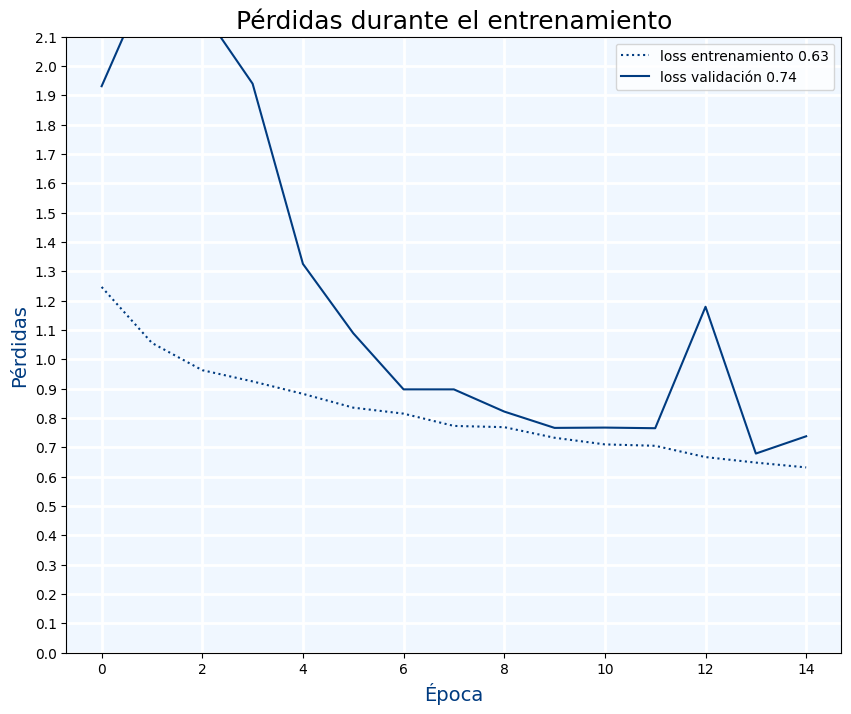

In [26]:
def plot_losses(history):
    last_epoch_loss = history.history['loss'][-1]
    last_epoch_val_loss = history.history['val_loss'][-1]

    figure = plt.figure(figsize=(10, 8))

    axes = figure.add_subplot(1, 1, 1)

    axes.plot(history.history['loss'], color="#003B80", linestyle="dotted",
              label=f"loss entrenamiento {last_epoch_loss:.2f}")
    axes.plot(history.history['val_loss'], color="#003B80", label=f"loss validación {last_epoch_val_loss:.2f}")

    axes.set_xlabel('Época', color="#003B80", fontsize=14)
    axes.set_ylabel('Pérdidas', color="#003B80", fontsize=14)

    axes.set_title('Pérdidas durante el entrenamiento', fontsize=18)
    axes.set_facecolor('#F0F7FF')
    axes.legend(loc="best")
    axes.grid(visible=True, which='major', axis='both', color="#FFFFFF", linewidth=2)
    axes.set_axisbelow(True)
    axes.set_ylim(ymin=0, ymax=2.1)
    axes.yaxis.set_major_locator(MultipleLocator(0.1))

    return figure


_ = plot_losses(history)

# Extracción de características

## Ejercicio 3

Vamos a hacer uso del modelo preentrenado Inception V3.

Descarga dicho modelo sin la última capa de clasificación con los pesos de ImageNet y congela todas las capas.

In [28]:
model_inception = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet',
                                                    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
model_inception.trainable = False

## Ejercicio 4

Crea un modelo con la siguiente arquitectura:
* Capa de preproceso necesaria.
* Modelo base
* Conversión matriz a vector mediante capa Flatten.
* Capa de salida con función de activación Softmax.

In [38]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input  # Not needed anymore 

input_layer = layers.Input((IMG_SIZE[0], IMG_SIZE[1], 3))
preprocess_layer = preprocess_input(input_layer)
base_layer = model_inception(preprocess_layer, training=False)
flatten = layers.Flatten()(base_layer)
output_layer = layers.Dense(5, activation="softmax")(flatten)

model_flowers = Model(inputs=[input_layer], outputs=[output_layer])
model_flowers.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_5 (Flatten)         (None, 51200)             0         
                                                                 
 dense_7 (Dense)             (None, 5)                 2560

## Ejercicio 5

- Compila el modelo haciendo uso del optimizador Adam, función de coste "sparse_categorical_crossentropy" y la exactitud como métrica.
- A continuación, entrena el modelo durante 10 épocas haciendo uso del callback ModelCheckpoint de forma que se almacene el modelo que mejores métricas ofrece en validación. Almacena el modelo como flowers.h5
- Una vez finalizado el entrenamiento visualiza las curvas de aprendizaje sobre entrenamiento y validación.
- Finalmente, visualiza las curvas de aprendizaje de validación obtenidas tras el entrenamiento del modelo de referencia (Ejercicio 2) y este.

In [39]:
model_flowers.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [40]:
history_transfer = model_flowers.fit(train_dataset,
                                     epochs=10,
                                     validation_data=validation_dataset,
                                     callbacks=[model_checkpoint_callback],
                                     verbose=True)

Epoch 1/10
92/92 [==============================] - ETA: 0s - loss: 2.6022 - accuracy: 0.7452
Epoch 1: val_accuracy improved from 0.75204 to 0.80926, saving model to C:\PersonalStuff\IABD\ProgramacionInteligenciaArtificial\Ana\Unit04-KnowledgeTransfer\Practices\Practice02\flowers.h5
92/92 [==============================] - 47s 477ms/step - loss: 2.6022 - accuracy: 0.7452 - val_loss: 1.7339 - val_accuracy: 0.8093
Epoch 2/10
92/92 [==============================] - ETA: 0s - loss: 0.8732 - accuracy: 0.8811
Epoch 2: val_accuracy improved from 0.80926 to 0.84060, saving model to C:\PersonalStuff\IABD\ProgramacionInteligenciaArtificial\Ana\Unit04-KnowledgeTransfer\Practices\Practice02\flowers.h5
92/92 [==============================] - 42s 457ms/step - loss: 0.8732 - accuracy: 0.8811 - val_loss: 1.4974 - val_accuracy: 0.8406
Epoch 3/10
92/92 [==============================] - ETA: 0s - loss: 0.2958 - accuracy: 0.9455
Epoch 3: val_accuracy did not improve from 0.84060
92/92 [================

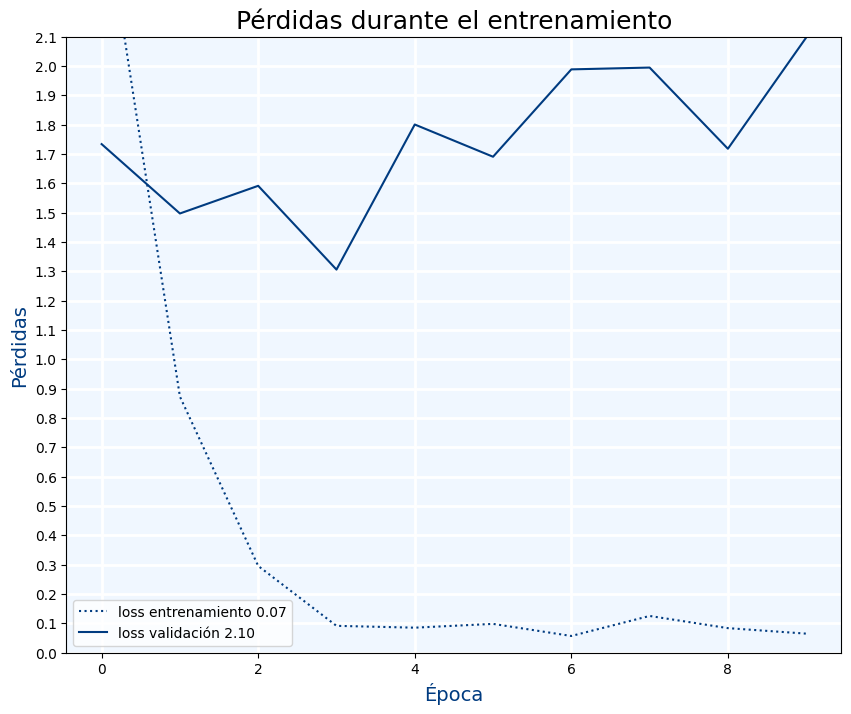

In [41]:
_ = plot_losses(history_transfer)

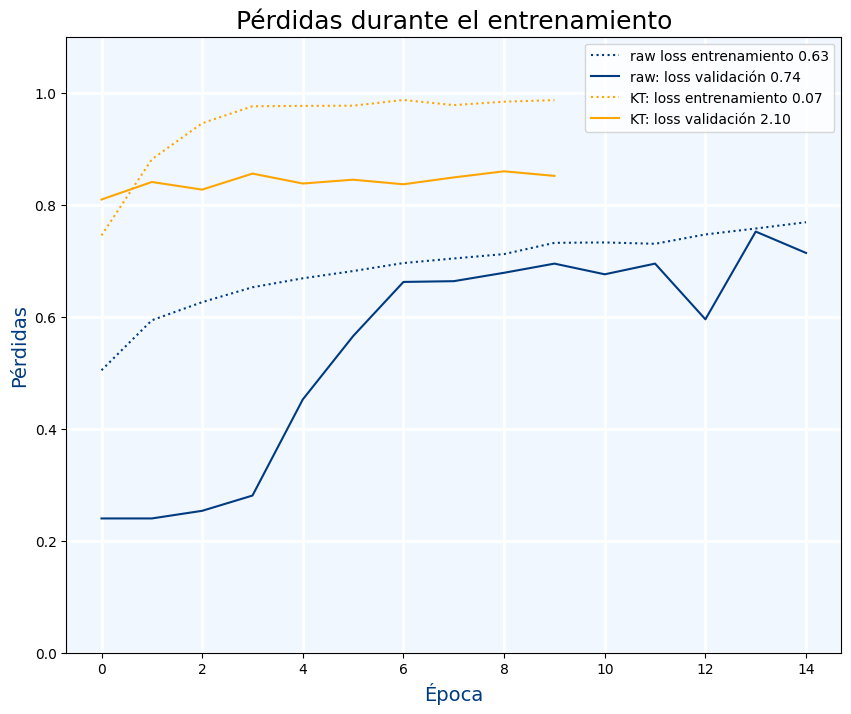

In [47]:
def plot_compare_losses(history_1, title_1, history_2, title_2):
    h1_last_epoch_loss = history_1.history['loss'][-1]
    h1_last_epoch_val_loss = history_1.history['val_loss'][-1]
    h2_last_epoch_loss = history_2.history['loss'][-1]
    h2_last_epoch_val_loss = history_2.history['val_loss'][-1]

    figure = plt.figure(figsize=(10, 8))

    axes = figure.add_subplot(1, 1, 1)

    axes.plot(history_1.history['loss'], color="#003B80", linestyle="dotted",
              label=f"{title_1} loss entrenamiento {h1_last_epoch_loss:.2f}")
    axes.plot(history_1.history['val_loss'], color="#003B80",
              label=f"{title_1}: loss validación {h1_last_epoch_val_loss:.2f}")
    axes.plot(history_2.history['loss'], color="#FFA500", linestyle="dotted",
              label=f"{title_2}: loss entrenamiento {h2_last_epoch_loss:.2f}")
    axes.plot(history_2.history['val_loss'], color="#FFA500",
              label=f"{title_2}: loss validación {h2_last_epoch_val_loss:.2f}")

    axes.set_xlabel('Época', color="#003B80", fontsize=14)
    axes.set_ylabel('Pérdidas', color="#003B80", fontsize=14)

    axes.set_title('Pérdidas durante el entrenamiento', fontsize=18)
    axes.set_facecolor('#F0F7FF')
    axes.legend(loc="best")
    axes.grid(visible=True, which='major', axis='both', color="#FFFFFF", linewidth=2)
    axes.set_axisbelow(True)
    axes.set_ylim(ymin=0, ymax=1.1)
    axes.yaxis.set_major_locator(MultipleLocator(0.2))

    return figure


_ = plot_compare_losses(history, 'raw', history_transfer, 'KT')

# Ajuste fino

## Ejercicio 6

Entrena el modelo anterior durante 5 épocas más para realizar un ajuste fino.
Para ello: descongela todas las capas, compila el modelo de nuevo pero esta vez con una tasa de aprendizaje inicial de 10^-7 y entrena durante 5 épocas más. Asegurate que ahora los parámetros de Inception también se va a antrenar.

Una vez finalizado el entrenamiento observa las curvas de aprendizaje.

In [ ]:
model_flowers.trainable = True

In [ ]:
model_flowers.compile(optimizer='adam', learning_rate=1e-7, metrics=['accuracy'])

In [ ]:
model_flowers.summary()

In [ ]:
history_fine = model_flowers.fit(train_dataset, epochs=5, validation_data=validation_dataset,
                                 callbacks=[model_checkpoint_callback])

## Visualización casos test

Finalmente vamos a visualizar las predicciones en algunos casos de test seleccionados de manera aleatoria (cada vez que ejecutéis la siguiente celda saldrán casos diferentes).

En este caso de clasificación multiclase veremos que la salida es diferente. Ahora, para cada imagen obtenemos a la salida un vector de 5 probabilidades (una por cada clase). Como clase final nos quedaremos con aquella que tenga la probabilidad más alta.

Predicción 1er ejemplo:  [2.1398370e-09 7.1815521e-07 1.1593676e-11 2.3701930e-01 7.6297998e-01]
Clase 1er ejemplo:  4 -> tulips


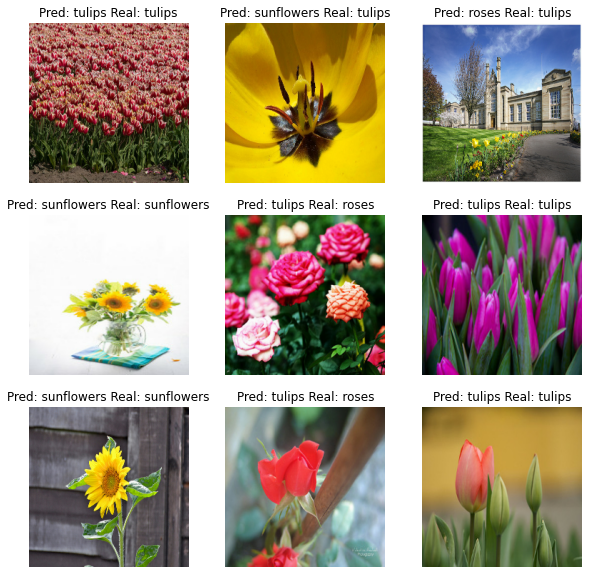

In [ ]:
# Visualizamos las predicciones en algunos casos de test cogidos aleatoriamente

# Cogemos un batch de imágenes del set de test
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model_flowers.predict_on_batch(image_batch)

print('Predicción 1er ejemplo: ', predictions[0])

# Para cada clase nos quedamos con el índice de la clase con mayor probabilidad
classes_predicted = np.argmax(predictions, axis=-1)
print('Clase 1er ejemplo: ', classes_predicted[0], '->', class_names[classes_predicted[0]])

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title('Pred: ' + class_names[classes_predicted[i]] + ' Real: ' + class_names[label_batch[i]])
    plt.axis("off")

# Ejercicio 7
Vamos a enfatizar en los pasos a seguir una vez la fase de entrenamiento, validación y test ha finalizado y tenemos que poner en producción el modelo obtenido.

Si no has almacenado el modelo "flowers.h5" en Drive descárgalo, en caso de haberlo almacenado en Drive no hace falta que lo descargues, haremos referencia directamente al directorio en el que este se encuentra almacenado.

Este archivo es el único que debemos almacenar tras entrenar un modelo (también deberemos de recordar los preprocesados hechos a la imagen en caso de no estar incluidos en la arquitectura, en nuestro caso, se encuentran incuidos dentro de la arquitectura del modelo preentrenado.

Finalmente, abre el Google Colab llamado "Inferencia".